## Inference
Test if we can run the saved models

In [1]:
import sys
import xarray as xr
import torch
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append('../src')
from Inference import sample_unet, sample_model_EDS
from Network import UNet, EDMPrecond
from DatasetUS import UpscaleDataset

from torch.utils.data.dataloader import DataLoader

Set up models

In [2]:
# Subset of years
year_start = 1953
year_end = 1954

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Dirs
data_dir="../data/"
model_dir="../"


cuda


Get checkpoints of models for both UNet and Diffusion

In [3]:
# Get models
# unet
model_unet = UNet((256, 128), 5, 3, label_dim=2, use_diffuse=False).to(device)
model_unet.load_state_dict(torch.load(f"{model_dir}/Model_chpt/unet.pt"))
# diffusion
model_diff = EDMPrecond((256, 128), 8, 3).to(device)
model_diff.load_state_dict(torch.load(f"{model_dir}/Model_chpt/diffusion.pt"))

<All keys matched successfully>

Open datasets

In [4]:
# define the datasets
datadir = "../data/"

dataset_test = UpscaleDataset(datadir, year_start=year_start, year_end=year_end,
                              constant_variables=["lsm", "z"])

lat = dataset_test.lat
lon = dataset_test.lon

nlat, nlon = len(lat), len(lon)

BATCH_SIZE = 1
dataloader = DataLoader(dataset_test,
                        batch_size=BATCH_SIZE,
                        shuffle=False)


Opening files
All files accessed. Creating tensors
torch.Size([3])
tensor([259.5524,  -6.4844,  -7.6029]) tensor([310.5276,   7.3752,   7.3651])
Opening constant variables file (e.g. land-sea mask, topography)
Normalize z
Mean:<xarray.DataArray 'z' ()>
array(4599.6445, dtype=float32), Std<xarray.DataArray 'z' ()>
array(6220.801, dtype=float32)
Dataset initialized.


 Sample our batch of 1 for both models

In [5]:
t = 0   # time index
test_batch = next(iter(dataloader))

# Run models
coarse, fine, predicted_unet = sample_unet(test_batch, model_unet, 
                                           device, dataset_test)
_, _, predicted_diff = sample_model_EDS(test_batch, model_diff, 
                                        device, dataset_test, num_steps=40)

coarse = coarse.detach().numpy()
fine = fine.detach().numpy()
predicted_unet = predicted_unet.detach().numpy()
predicted_diff = predicted_diff.detach().numpy()


In [6]:
print(coarse.shape, fine.shape, predicted_unet.shape, predicted_diff.shape)

(1, 3, 128, 256) (1, 3, 128, 256) (1, 3, 128, 256) (1, 3, 128, 256)


## Plot
Plot all three variables for this one timestep

In [7]:
# Variables - defines three separate subplots
varnames = ["VAR_2T", "VAR_10U", "VAR_10V"]
vmin = [250, -10, -10]
vmax = [300, 10, 10]
vmax_stds = [3, 1, 1]
cmaps = ["rainbow", "BrBG_r", "BrBG_r"]

plot_varnames = ["Temperature", "Zonal wind", "Meridional wind"]
plot_var_labels = ["K", "m/s", "m/s"]
plt.rcParams.update({'font.size': 18})

<Figure size 640x480 with 0 Axes>

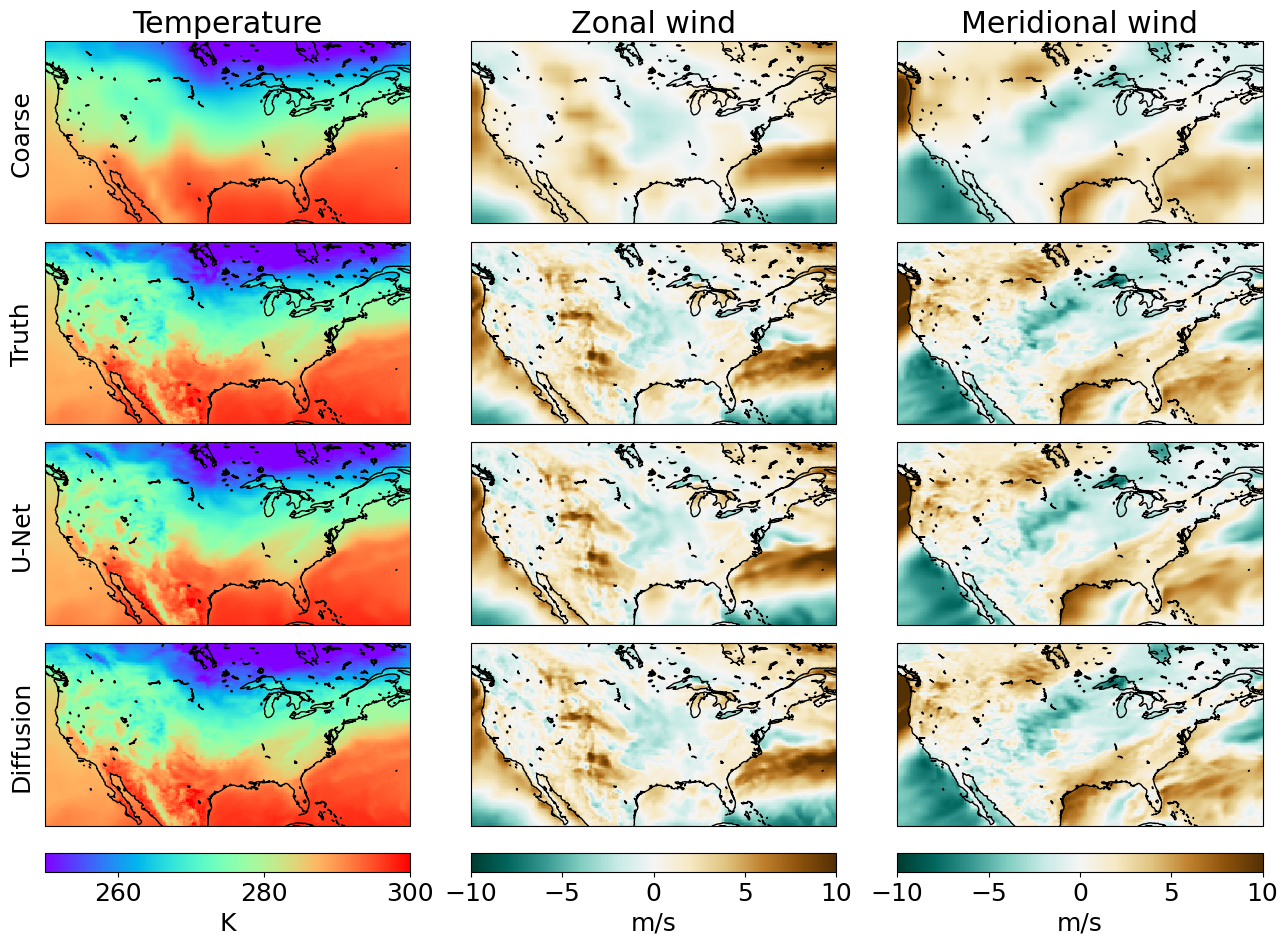

In [8]:
plt.clf()
fig, axs = plt.subplots(4,3, figsize=(16, 10.2),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        gridspec_kw={'wspace': 0.1,
                                     'hspace': 0.1})
for i, varname in enumerate(varnames):

    # Plot truth for first plot
    ax = axs[0, i]
    plt.sca(ax)
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
    pcm = plt.pcolormesh(lon, lat, coarse[0, i],
                   vmin=vmin[i], vmax=vmax[i],
                   shading='nearest',
                   cmap=cmaps[i])
    plt.title(f"{plot_varnames[i]}")
    if i == 0:
        plt.text(lon[0]-2, lat[len(lat) // 2], f"Coarse", transform=ccrs.PlateCarree(),
                 rotation='vertical', ha='right', va='center', zorder=10)

    ax = axs[1, i]
    plt.sca(ax)
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
    pcm = plt.pcolormesh(lon, lat, fine[0, i],
                   vmin=vmin[i], vmax=vmax[i],
                   shading='nearest',
                   cmap=cmaps[i])
    if i == 0:
        plt.text(lon[0]-2, lat[len(lat) // 2], f"Truth", transform=ccrs.PlateCarree(),
                 rotation='vertical', ha='right', va='center', zorder=10)

    ax = axs[2, i]
    plt.sca(ax)
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
    pcm = plt.pcolormesh(lon, lat, predicted_unet[0, i],
                   vmin=vmin[i], vmax=vmax[i],
                   shading='nearest',
                   cmap=cmaps[i])
    if i == 0:
        plt.text(lon[0]-2, lat[len(lat) // 2], f"U-Net", transform=ccrs.PlateCarree(),
                 rotation='vertical', ha='right', va='center', zorder=10)

    ax = axs[3, i]
    plt.sca(ax)
    ax.coastlines()
    ax.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor='none')
    pcm = plt.pcolormesh(lon, lat, predicted_diff[0, i],
                   vmin=vmin[i], vmax=vmax[i],
                   shading='nearest',
                   cmap=cmaps[i])
    if i == 0:
        plt.text(lon[0]-2, lat[len(lat) // 2], f"Diffusion", transform=ccrs.PlateCarree(),
                 rotation='vertical', ha='right', va='center', zorder=10)
    cax = axs[3, i].inset_axes([0., -0.25, 1, 0.1])
    plt.colorbar(pcm, cax = cax, orientation="horizontal", label=f"{plot_var_labels[i]}")

plt.show()